# 4. Higgs@L3

Here we go back to using a one-dimensional distribution (in `mmis`).
BDTs are used for the preselection.

## Prerequisites

The BDT responsed for each of the mass hypothesis is needed to run this notebook.

## Some information on the MC simulation and detector data sets

## (1D) Likelihood analysis

## Quantile plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from higgs_search.helpers import higgs_hypotheses, variable_info
from higgs_search.plotting import BkgSigHistos, LogLikRatioPlots
from higgs_search.stats import LogLikRatio, LogLikRatioObserved

## Some information on the MC simulation and detector data sets

In [2]:
from higgs_search.load_data import data, mc_higgs_models, mc_no_higgs_frames, getPreselectedSBD

\begin{array}{|l||c|c|c|c|}
\hline
\textrm{sample name} & \textrm{type of data} & \textrm{real data} & \textrm{No. of events} & \sigma   [\textrm{pb}] \\ \hline
\textrm{higgs_qq} & q \bar{q} & - & 200000 & 102 \\ \hline
\textrm{higgs_ww} & W^+ W^- & - & 294500 & 16.5 \\ \hline
\textrm{higgs_zz} & ZZ & - & 196000 & 0.975 \\ \hline
\textrm{higgs_zee} & Z e^+ e^- & - & 29500 & 3.35 \\ \hline
\textrm{higgs_wen} & q \bar{q} e \nu_e & - & 81786 & 2.90 \\ \hline
\textrm{higgs_eeqq} & \textrm{two photon coll} & - & 5940000 & 15600 \\ \hline
\textrm{higgs_data} & \textrm{data} & x & - & - \\ \hline
\textrm{higgs_higgs_85} & \textrm{Higgs} (m_{H} = 85 \ \textrm{GeV}) & - & 3972 & 0.0940\\ \hline
\textrm{higgs_higgs_90} & \textrm{Higgs} (m_{H} = 90 \ \textrm{GeV}) & - & 3973 & 0.0667\\ \hline
\textrm{higgs_higgs_95} & \textrm{Higgs} (m_{H} = 95 \ \textrm{GeV}) & - & 3971 & 0.0333\\ \hline	
\end{array}

### Introduce weights in order to rescale all the MC samples to the same luminosity

per definition the weight of each measured event (data) is $1$. 
Thus, we want to rescale the MC to the same integrated Luminosity of the data taking which is $L = 176.773 \ \mathrm{pb}^{-1}$.

The weight for each MC sample is:
$$ 
        \mathrm{weight}_\mathrm{MC} = L \cdot  \frac{\sigma_\mathrm{MC} }{N_\mathrm{MC}}
$$

### Preselection: Cut on the BDT value

In [3]:
sig, bkg, dat = getPreselectedSBD()

### Purity in range $90 \pm 5$ GeV

In [4]:
for higgs_mass in mc_higgs_models:
    s = sig[higgs_mass]
    b = bkg[higgs_mass]
    sig_in_interval = s[(s["mmis"] < 95) & (s["mmis"] > 85)]["weight"].sum()
    bkg_in_interval = b[(b["mmis"] < 95) & (b["mmis"] > 85)]["weight"].sum()

    purity = sig_in_interval / bkg_in_interval
    print(f"{higgs_mass}: Purity = {100*purity:.2f} % with {len(dat[higgs_mass]):2} observed events.")

higgs_85: Purity = 0.40 % with 641 observed events.
higgs_90: Purity = 3.01 % with 638 observed events.
higgs_95: Purity = 1.56 % with 631 observed events.


### Distribution in variable of interest

In [5]:
variable = "mmis"

binning = variable_info[variable]["binning"]
bkg_histos = {}
sig_histos = {}
data_histos = {}

for higgs_mass in sig:
    sig_histos[higgs_mass] = np.histogram(
           sig[higgs_mass][variable], bins=binning, weights=sig[higgs_mass]["weight"])[0]
    bkg_histos[higgs_mass] = np.histogram(
           bkg[higgs_mass][variable], bins=binning, weights=bkg[higgs_mass]["weight"])[0]
    data_histos[higgs_mass] = np.histogram(
           dat[higgs_mass][variable], bins=binning, weights=dat[higgs_mass]["weight"])[0]  

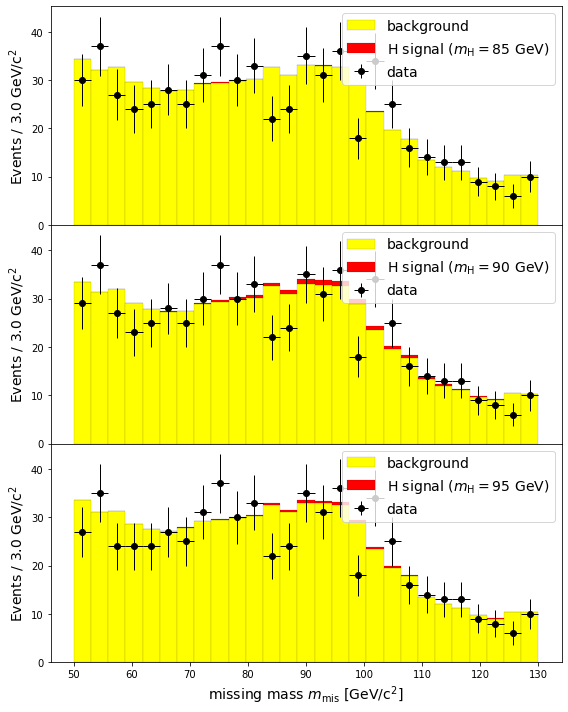

In [6]:
BkgSigHistos(backgrounds=bkg_histos, signals=sig_histos, datas=data_histos,
             var=variable, binning=binning,
             # asymm_errors=True,
)
plt.savefig(f"plots/histos_preselected_{variable}.png", facecolor="white")

## (1D) Likelihood analysis

The Log-likelihood ratio is defined as

$$
    -2 \log (Q(m_H)) = 2 s_{tot} - 2 \sum_{i=1}^{N_{bins}} N_i \log \left( 1 + \frac{s_i(m_H)}{b_i} \right)
$$.

In [7]:
n_exp = 10000
llrs, llrs_obs = {}, {}
for higgs_mass in bkg_histos:
    llrs[higgs_mass] = LogLikRatio(
        background=bkg_histos[higgs_mass],
        signal=sig_histos[higgs_mass],
        n_experiments=n_exp
    )
    llrs_obs[higgs_mass] = LogLikRatioObserved(
        background=bkg_histos[higgs_mass], 
        signal=sig_histos[higgs_mass],
        data=data_histos[higgs_mass],
    )

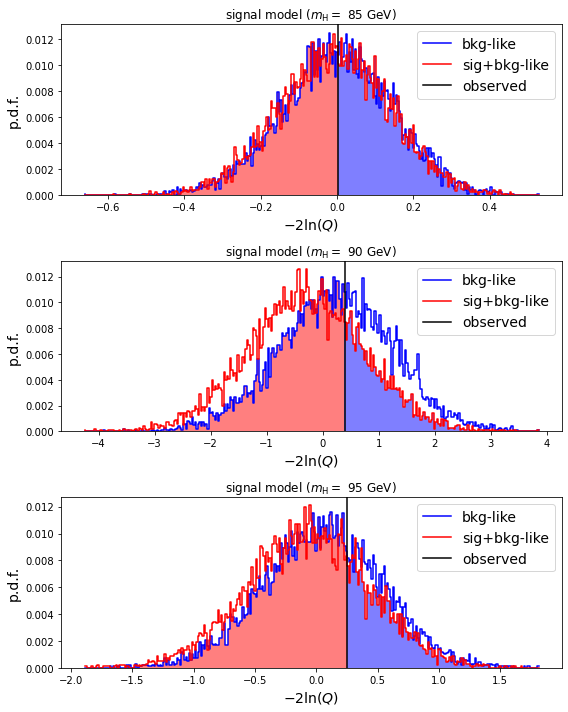

In [8]:
cl_s_and_b, quantiles_b, quantiles_s_plus_b = LogLikRatioPlots(llrs, llrs_obs, n_bins=300)
plt.savefig(f"plots/llr_preselected_{variable}", facecolor="white")

# Quantile plot

$$CL_s = \frac{CL_{s+b}}{CL_b} = \frac{CL_{s+b}}{1-(1-CL_b)}$$

In [9]:
for higgs_mass in cl_s_and_b:
    one_minus_cl_b, cl_s_plus_b = cl_s_and_b[higgs_mass]
    cl_s = cl_s_plus_b / (1 - one_minus_cl_b) 
    print(f"{higgs_mass}: Confidence level CL >= {cl_s:.3f}")

higgs_85: Confidence level CL >= 0.959
higgs_90: Confidence level CL >= 0.580
higgs_95: Confidence level CL >= 0.779


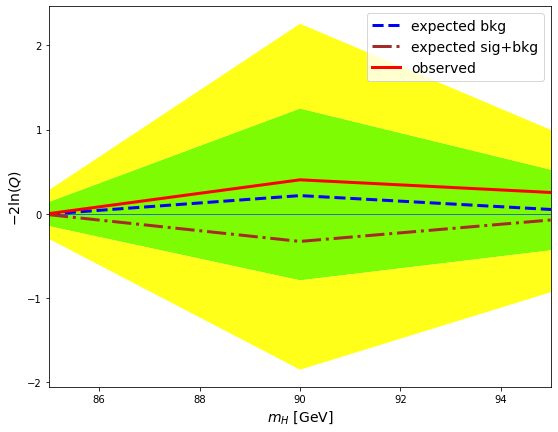

In [10]:
plt.figure(figsize=(9,7))
fontsize = 14


x = [int(m_h[-2:]) for m_h in higgs_hypotheses]
obs = [llrs_obs[m_h] for m_h in higgs_hypotheses]
y_s_plus_b = [quantiles_s_plus_b[m_h][0] for m_h in higgs_hypotheses]
y_b = [quantiles_b[m_h][0] for m_h in higgs_hypotheses]
y_b_one_sigma_lower = [quantiles_b[m_h][1][0] for m_h in higgs_hypotheses]
y_b_one_sigma_upper = [quantiles_b[m_h][1][1] for m_h in higgs_hypotheses]
y_b_two_sigma_lower = [quantiles_b[m_h][2][0] for m_h in higgs_hypotheses]
y_b_two_sigma_upper = [quantiles_b[m_h][2][1] for m_h in higgs_hypotheses]

plt.fill_between(x, y_b_one_sigma_lower, y_b_one_sigma_upper, 
                 facecolor="lawngreen",alpha=0.99)
plt.fill_between(x, y_b_two_sigma_lower, y_b_one_sigma_lower,
                 facecolor="yellow", alpha=0.9)
plt.fill_between(x, y_b_two_sigma_upper, y_b_one_sigma_upper,
                 facecolor="yellow", alpha=0.9)
plt.plot(x, y_b, "b--", label="expected bkg", linewidth=3)
plt.plot(x, y_s_plus_b , "-.", label="expected sig+bkg", color="brown", linewidth=3)
plt.plot(x, obs, "r-", label="observed", linewidth=3)

plt.hlines(0, min(x), max(x),linewidth=1)
plt.xlim(min(x), max(x))
plt.xlabel("$m_{H}$ [GeV]",fontsize=fontsize)
plt.ylabel("$-2 \ln (Q)$",fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.savefig("plots/quantile_plot.png", facecolor="white")

### $1 - CL_b$ plots

In [11]:
n_pseudo_experiments = 1000
cl_one_minus_b = {higgs_mass: np.zeros(n_pseudo_experiments) for higgs_mass in bkg_histos}
llr_pseudo_observed = {higgs_mass: np.zeros(n_pseudo_experiments) for higgs_mass in bkg_histos}

llr_hist, binning = np.histogram(llrs[higgs_mass][0] , bins=300)
llr_hist = llr_hist / len(llrs[higgs_mass][0])

for i in range(n_pseudo_experiments):
    for higgs_mass in bkg_histos:
        n_s_plus_b_pseudo = np.random.poisson(lam=sig_histos[higgs_mass]+bkg_histos[higgs_mass])   
        llr_pseudo_observed = LogLikRatioObserved(background=bkg_histos[higgs_mass],
                                                    signal=sig_histos[higgs_mass],
                                                    data=n_s_plus_b_pseudo)
        try:
            pos = np.where(binning <= llr_pseudo_observed)[0][-1]
            cl_one_minus_b[higgs_mass][i] = sum(llr_hist[:pos])
        except IndexError:
            cl_one_minus_b[higgs_mass][i] = 0

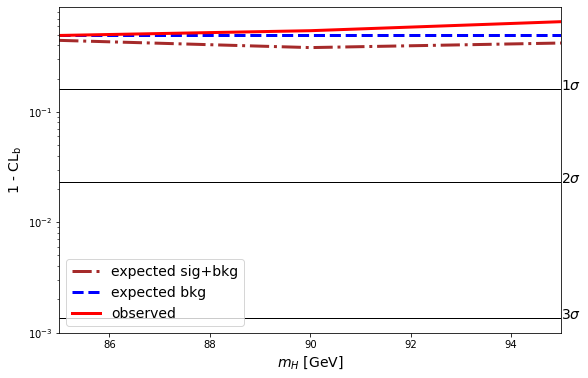

In [12]:
plt.figure(figsize=(9,6))
x = [int(m_h[-2:]) for m_h in higgs_hypotheses]
plt.plot(x, [np.mean(cl_one_minus_b[m_h]) for m_h in higgs_hypotheses],
         "-.", color="brown", label="expected sig+bkg", linewidth=3)
plt.plot(x, [0.5, 0.5, 0.5],
         "--", color="blue", label="expected bkg", linewidth=3)
plt.plot(x, [cl_s_and_b[m_h][0] for m_h in higgs_hypotheses],
         "r-", label="observed", linewidth=3)

for pos, n_sigma in [(.16, "1"), (.023, "2"), (1.35*10**(-3), "3")]:
    plt.hlines(pos, min(x), max(x), color="k", linewidth=1)
    plt.text(max(x), pos, f"${n_sigma} \sigma$", fontsize=14)
plt.semilogy()
plt.xlim(min(x), max(x))
plt.legend(fontsize=14, loc="best")
plt.xlabel("$m_{H}$ [GeV]", fontsize=14)
plt.ylabel("1 - CL${}_\mathrm{b}$", fontsize=14)
plt.savefig("plots/one_minus_cl_b.png", facecolor="white")